In [1]:
# 단층 퍼셉트론 구현

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
    
# XOR 문제
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

linear = nn.Linear(2, 1, bias=True)
sigmoid = nn.Sigmoid()
model = nn.Sequential(linear, sigmoid).to(device)

criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1)

for step in range(10001):
    optimizer.zero_grad()
    hypothesis = model(X)
    
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()
    if step % 1000 == 0:
        print(step, cost.item())
        
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('hypothesis:', hypothesis.detach().cpu().numpy())
    print('predicted:', predicted.detach().cpu().numpy())
    print('Y:', Y.cpu().numpy())
    print('accuracy:', accuracy.item())

0 0.7273974418640137
1000 0.6931471824645996
2000 0.6931471824645996
3000 0.6931471824645996
4000 0.6931471824645996
5000 0.6931471824645996
6000 0.6931471824645996
7000 0.6931471824645996
8000 0.6931471824645996
9000 0.6931471824645996
10000 0.6931471824645996
hypothesis: [[0.5]
 [0.5]
 [0.5]
 [0.5]]
predicted: [[0.]
 [0.]
 [0.]
 [0.]]
Y: [[0.]
 [1.]
 [1.]
 [0.]]
accuracy: 0.5


In [2]:
# 다중 퍼셉트론 구현

import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
    
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

model = nn.Sequential(
    nn.Linear(2, 10, bias=True),
    nn.Sigmoid(),
    nn.Linear(10, 10, bias=True),
    nn.Sigmoid(),
    nn.Linear(10, 10, bias=True),
    nn.Sigmoid(),
    nn.Linear(10, 1, bias=True),
    nn.Sigmoid()).to(device)

criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1)

for epoch in range(10001):
    optimizer.zero_grad()
    hypothesis = model(X)
    
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(epoch, cost.item())

with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('hypothesis: ', hypothesis.detach().cpu().numpy())
    print('predicted: ', predicted.detach().cpu().numpy())
    print('Y: ', Y.cpu().numpy())
    print('accuracy: ', accuracy.item())

0 0.6948983669281006
1000 0.6931380033493042
2000 0.6931171417236328
3000 0.6930763125419617
4000 0.6929103136062622
5000 0.6820820569992065
6000 0.0013024783693253994
7000 0.0004836485313717276
8000 0.00028899149037897587
9000 0.0002038097009062767
10000 0.0001565046259202063
hypothesis:  [[1.1169227e-04]
 [9.9982882e-01]
 [9.9984241e-01]
 [1.8534942e-04]]
predicted:  [[0.]
 [1.]
 [1.]
 [0.]]
Y:  [[0.]
 [1.]
 [1.]
 [0.]]
accuracy:  1.0


In [28]:
# 다층 퍼셉트론으로 MNIST 분류

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.int8)

X = mnist.data / 255 # 0 - 255 값을 [0, 1] 구간으로 정규화
y = mnist.target

In [29]:
# 학습/테스트 데이터 분리

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

In [31]:
# 다층 퍼셉트론

from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [32]:
from torch import optim

# 오차함수 선택
loss_fn = nn.CrossEntropyLoss()

# 가중치 학습을 위한 최적화 기법 선택
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [38]:
def train(epoch):
    model.train()
    
    for data, targets in loader_train:
        optimizer.zero_grad() # 경사 0으로 초기화
        outputs = model(data) # 데이터 입력하고 출력 계산
        loss = loss_fn(outputs, targets) # 출력과 정답 간의 오차 계산
        loss.backward() # 오차역전파
        optimizer.step() # 역전파 계산한 값으로 가중치 수정
    print('epoch{}: 완료'.format(epoch))

In [39]:
def test():
    model.eval()
    correct = 0
    
    with torch.no_grad(): # 추론할땐 미분값이 필요없음
        for data, targets in loader_test:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            correct += predicted.eq(targets.data.view_as(predicted)).sum()
            data_num = len(loader_test.dataset)
            data_num = len(loader_test.dataset)
            print('테스트 데이터에서 예측 정확도: {}/{} ({:.0f}%)'.format(
                correct, data_num, 100. * correct / data_num))

In [40]:
for epoch in range(3):
    train(epoch)

test()

epoch0: 완료
epoch1: 완료
epoch2: 완료
테스트 데이터에서 예측 정확도: 63/10000 (1%)
테스트 데이터에서 예측 정확도: 126/10000 (1%)
테스트 데이터에서 예측 정확도: 189/10000 (2%)
테스트 데이터에서 예측 정확도: 250/10000 (2%)
테스트 데이터에서 예측 정확도: 308/10000 (3%)
테스트 데이터에서 예측 정확도: 368/10000 (4%)
테스트 데이터에서 예측 정확도: 430/10000 (4%)
테스트 데이터에서 예측 정확도: 493/10000 (5%)
테스트 데이터에서 예측 정확도: 553/10000 (6%)
테스트 데이터에서 예측 정확도: 616/10000 (6%)
테스트 데이터에서 예측 정확도: 673/10000 (7%)
테스트 데이터에서 예측 정확도: 733/10000 (7%)
테스트 데이터에서 예측 정확도: 795/10000 (8%)
테스트 데이터에서 예측 정확도: 857/10000 (9%)
테스트 데이터에서 예측 정확도: 917/10000 (9%)
테스트 데이터에서 예측 정확도: 977/10000 (10%)
테스트 데이터에서 예측 정확도: 1039/10000 (10%)
테스트 데이터에서 예측 정확도: 1101/10000 (11%)
테스트 데이터에서 예측 정확도: 1165/10000 (12%)
테스트 데이터에서 예측 정확도: 1226/10000 (12%)
테스트 데이터에서 예측 정확도: 1289/10000 (13%)
테스트 데이터에서 예측 정확도: 1349/10000 (13%)
테스트 데이터에서 예측 정확도: 1412/10000 (14%)
테스트 데이터에서 예측 정확도: 1475/10000 (15%)
테스트 데이터에서 예측 정확도: 1536/10000 (15%)
테스트 데이터에서 예측 정확도: 1599/10000 (16%)
테스트 데이터에서 예측 정확도: 1662/10000 (17%)
테스트 데이터에서 예측 정확도: 1726/10000 (17%)
테스트 데이터에서 예측 정확도: 1

예측 결과 : 2
이 이미지 데이터의 정답 레이블은 2입니다


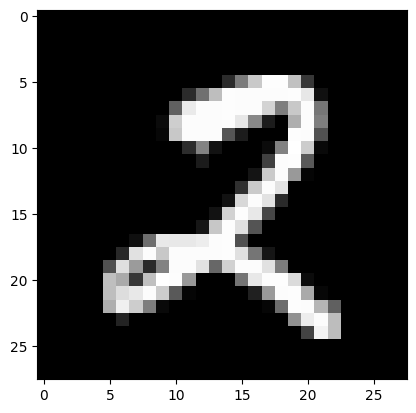

In [41]:
index = 2018

model.eval()  # 신경망을 추론 모드로 전환
data = X_test[index]
output = model(data)  # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 0)  # 확률이 가장 높은 레이블이 무엇인지 계산

print("예측 결과 : {}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 정답 레이블은 {:.0f}입니다".format(y_test[index]))